## Import Statements

In [1]:
# Plotting settings
from matplotlib import gridspec, rc
from matplotlib import ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from numpy.random.mtrand import beta
from sklearn.preprocessing import normalize

from subpop import *
from learner_utils import *

%matplotlib inline

np.set_printoptions(precision=3, suppress=True)

In [2]:
## Plotting settings
rc('text', usetex = False)
rc('font', family = 'serif')
TITLE_SIZE = 13
LABEL_SIZE = 11
LEGEND_TITLE_SIZE = 12
LEGEND_SIZE = 11
TICK_SIZE = 11
FONT = 'serif'
params = {}
params['legend.title_fontsize'] = LEGEND_TITLE_SIZE
params['axes.labelsize'] = LABEL_SIZE
params['axes.titlesize'] = TITLE_SIZE
params['legend.fontsize'] = LEGEND_SIZE
params["xtick.labelsize"]= TICK_SIZE
params["ytick.labelsize"] = TICK_SIZE
params["font.family"] = "Times New Roman"
context = sns.plotting_context("paper", rc=params)
sns.set_theme(style="whitegrid", font=FONT)

## Dynamics Simulation

In [3]:
def run_experiment(T, subpops, rr=False, min_fn=quadratic_min, early_stop=False, verbose = True):
    n_learners = len(subpops[0].alphas)
    if verbose:
        print("Initial Conditions:")
        print(f"There are {n_learners} initial learners")
        print(f"Subpopulation splits: {[s.beta for s in subpops]}")
        print(f"Initial allocations: {[s.alphas for s in subpops]}")
        print(f"Optimal decisions theta for each subpop (row-wise) {[s.phi for s in subpops]}")
    average_risks_subpop = []
    average_risks_learner = []
    all_risks = []
    all_thetas = []
    all_alphas = []
    for t in range(T):
        if rr and t>0:
            learner = t%n_learners
            theta_learner = np.array(learner_decisions(subpops, current=learner))
            thetas[learner] = theta_learner
            thetas = copy.deepcopy(thetas)
            all_thetas.append(thetas)
        else:
            thetas = np.array(learner_decisions(subpops,  min_fn=min_fn))
        alpha = subpop_decisions(thetas, subpops)
        all_thetas.append(thetas)
        all_alphas.append(alpha.T)
        risks = get_all_risks(thetas, subpops)
        all_risks.append(risks)
        a_risk_subpop = average_risk_subpop(thetas, subpops)
        average_risks_subpop.append(a_risk_subpop)
        a_risk_learner = average_risk_learner(thetas, subpops)
        average_risks_learner.append(a_risk_learner)
        if early_stop:
            c_counts = convergent_count(subpops)
            if min(c_counts) > 20:
                break
    if verbose:
        print("Final Conditions:")
        print(f'\t\tLearners decisions: {thetas}')
        print(f'\t\tSubpopulation allocations: {alpha}')
    return(average_risks_subpop, average_risks_learner, all_risks, all_thetas, all_alphas) 

## Figure 1: Risk profiles over time

In [5]:
def plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, ls= '-', lw=2, legend = False):
    
    n_learners, n_subpops = all_risks[0].shape
    c = ['tab:blue', 'tab:orange', 'tab:green']
    for subpop in range(n_subpops-2):
        # Average Losses of the subpops
        axs[0].plot([a[subpop] for a in average_risks_subpop], color = c[subpop], ls= ls, lw=lw,label = f"Subpop {subpop + 1}")
        axs[0].set_xlabel('Time t')
        axs[0].set_ylabel('Risk')
        axs[0].set_title('Average Subpopulation risk over time')
        if legend:
            axs[0].legend()


    for learner in range(n_learners-1):     
        # Learner Risks
        learner = learner-1
        axs[1].plot([a[learner] for a in average_risks_learner], color = c[learner], ls= ls, lw=lw , label = f"Learner {learner + 1}")
        axs[1].set_xlabel('Time t')
        axs[1].set_ylabel('Risk')
        axs[1].set_title('Average Learner risk over time')
        if legend:
            axs[1].legend()
    
    total_risk = [np.sum(round_risks) for round_risks in all_risks]
    axs[2].plot(total_risk, ls= ls, lw=lw+1, c = 'k')
    axs[2].set_xlabel('Time t')
    axs[2].set_ylabel('Risk')
    axs[2].set_title('Total risk over time')
    #axs[1].legend()
    

In [6]:
def run_trial(allocation=None, min_fn = quadratic_min):
    T = 500
    # relative sizes
    beta_1 = 1
    beta_2 = 1 
    beta_3 = 1
    # initial allocations
    if allocation is  None:
        dist = np.array([[0.01, 0.02, -0.04], [-0.01,-0.01, 0.02]])
        dist = np.random.rand(2,3)*0.1
        alpha = np.array([[1,1, 1], [1,1, 1]]) + dist
        # alpha_ij <- fraction of subpop j going to learner i
        alpha =  normalize(alpha, axis=0, norm='l1')   
    else:
        alpha = allocation
    # optimal thetas for each subpop
    phi_1 = np.array([0, 1])
    phi_2 = np.array([1, 1])
    phi_3 = np.array([0.6, 0])
    # phi = np.array([phi_1, phi_2])

    pop1 = QuadraticSubPop(phi_1, beta_1, alpha[:,0])
    pop2 = QuadraticSubPop(phi_2, beta_2, alpha[:,1])
    pop3 = QuadraticSubPop(phi_3, beta_3, alpha[:,2])
    subpops = [pop1, pop2, pop3]

    # Run dynamics and create plots
    (average_risks_subpop, average_risks_learner, all_risks, _, _) = run_experiment(T, subpops, min_fn=min_fn, rr=False)
    
    return(average_risks_subpop, average_risks_learner, all_risks)


Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.5, 0.5]), array([0.5, 0.5]), array([0.5, 0.5])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Learners decisions: [[0.6 0. ]
 [0.5 1. ]]
		Subpopulation allocations: [[0. 1.]
 [0. 1.]
 [1. 0.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.496, 0.504]), array([0.511, 0.489]), array([0.498, 0.502])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Learners decisions: [[1.  1. ]
 [0.3 0.5]]
		Subpopulation allocations: [[0. 1.]
 [1. 0.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.501, 0.499]), array([0.491, 0.509]), array([0.494, 0.506])]
Optimal decisions theta for each subpop (row-wise) [ar

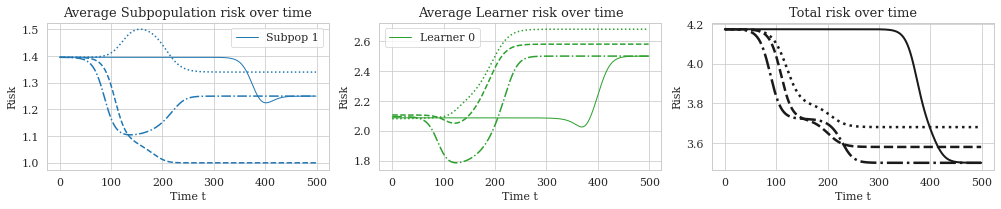

In [7]:
allocations = [None]*4 #<- select this to run experiments  with new random initial conditions
allocations = [np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
               np.array([[0.496, 0.511, 0.498], [0.504, 0.489, 0.502]]),
               np.array([[0.501, 0.491, 0.494], [0.499, 0.509, 0.506]]),
               np.array([[0.486, 0.505, 0.503], [0.514, 0.495, 0.497]]),
               ]  #<- select this to reproduce plots in the paper 
min_fn = quadratic_min #<- select this for noiseless updates from the learners
min_fn = noisy_quadratic_min #<- select this for noisy setting
          
with context:
    fig, axs = plt.subplots(1,3, figsize = (14,3))
    for t in range(4):
        (average_risks_subpop, average_risks_learner, all_risks) = run_trial(allocations[t], min_fn)
        if t >0:
            lw = 1.5
            if t == 1:
                ls = ':'
            if t == 2:
                ls = '--'
            if t ==3:
                ls = '-.'
            legend = False
        else: 
            lw = 1
            ls = '-'
            legend = True
        plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, ls=ls, lw = lw, legend=legend)
    plt.tight_layout()
fig.savefig('risk_dynamics.pdf')

## Increased competition experiments

In [8]:
def run_competition_experiment(T, subpops, n_learners_max=None, min_fn=noisy_quadratic_min):
    n_learners_init = len(subpops[0].alphas)
    if n_learners_max is None:
        n_learners_max = len(subpops)
    print("Initial Conditions:")
    print(f"There are {n_learners_init} initial learners")
    exp_out = run_experiment(T, subpops, rr=False, early_stop=True, verbose=False, min_fn = min_fn)
    average_risks_subpop, average_risks_learner, all_risks, all_thetas, all_alphas = exp_out
    total_average_risks_subpop_over_time = {-1: average_risks_subpop}
    for i in range(n_learners_max - n_learners_init):
        for subpop in subpops:
            subpop.break_learner(i)
        exp_out = run_experiment(T, subpops, rr=False, early_stop=True, verbose=False, min_fn = min_fn)  
        total_average_risks_subpop_over_time[i] = exp_out[0]
    return(total_average_risks_subpop_over_time)

In [9]:
seed = 10
rng = np.random.default_rng(seed)
T = 1000
n_subpops = 50
n_learners_init = 2
d = 8
# relative sizes
beta = 1
# initial allocations
dist = rng.random(size=(n_learners_init,n_subpops))*0.0001
alpha = np.ones(shape=(n_learners_init,n_subpops)) + dist
# alpha_ij <- fraction of subpop j going to learner i
alpha =  normalize(alpha, axis=0, norm='l1')

# optimal thetas for each subpop
phi = rng.normal(size=(n_subpops, d))
subpops = [QuadraticSubPop(phi[i,:], beta, alpha[:,i]) for i in range(n_subpops)]

In [13]:
res = run_competition_experiment(T, subpops, n_learners_max=None, min_fn=noisy_quadratic_min)

Initial Conditions:
There are 50 initial learners


In [11]:
average_res= {k:np.mean(np.array(v), 1) for k, v in res.items()}
subpop_equilibrium_res = {k:v[-1] for k, v in res.items()}
average_equilibrium_res= {k:v[0] for k, v in average_res.items()}
break_times = {k:len(v) for k, v in average_res.items()}
break_times = np.cumsum(list(break_times.values()))

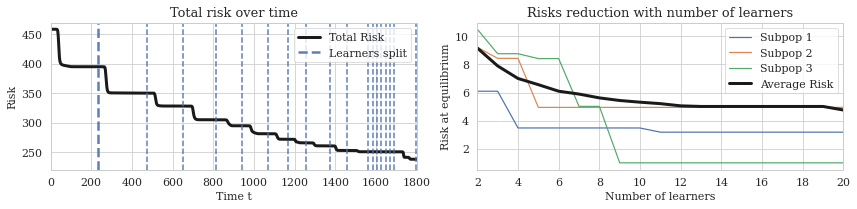

In [12]:
selected_subpops = [1,2,3] #<- choose different subpopulations to plot the risk of alongside with total average risk.
with context:
    fig, axs = plt.subplots(1,2, figsize = (12,3))
    axs[0].plot(n_subpops*np.concatenate((list(average_res.values()))), c='k', lw =3, label = 'Total Risk')
    for i, bt in enumerate(break_times):
        if i == 0:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 2.5, label='Learners split')
        else:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 1.5)
    axs[0].legend(loc = 1)
    axs[0].set_xlim([0, 1800])
    eq_risks = np.array(list(subpop_equilibrium_res.values()))
    axs[1].plot(range(n_learners_init, n_learners_init+len(eq_risks)), eq_risks[:,selected_subpops], label ='Subpop')
    axs[1].plot(range(n_learners_init, n_learners_init+len(eq_risks)), 
                list(average_equilibrium_res.values()), c='k', lw =3, label = 'Average Risk')
    axs[1].legend()
    axs[1].set_xlim([2, 20])
    axs[0].set_xlabel('Time t')
    axs[1].set_xlabel('Number of learners')
    axs[0].set_ylabel('Risk')
    axs[1].set_ylabel('Risk at equilibrium')
    axs[0].set_title('Total risk over time')
    axs[1].set_title('Risks reduction with number of learners')
    h, l = axs[1].get_legend_handles_labels()
    axs[1].legend(h, ['Subpop 1', 'Subpop 2', 'Subpop 3', 'Average Risk'])
    plt.tight_layout()
    fig.savefig('competition.pdf')